# Avellaneda-Stoikov

In [ ]:
import sys
sys.path.append("../") # This version of the notebook is in the subfolder "notebooks" of the repo

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy


from mbt_gym.agents.BaselineAgents import *
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.helpers.plotting import *
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.arrival_models import *
from mbt_gym.stochastic_processes.fill_probability_models import *
import torch
#print(torch.cuda.is_available())
#print(torch.cuda.get_device_name())

## Avellaneda-Stoikov Optimal Strategy

In [ ]:
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics
seed = 50

In [ ]:
def get_as_env(num_trajectories:int = 1):
    initial_price = 100
    terminal_time = 1.0
    sigma = 2.0
    n_steps = 200
    initial_inventory = 0
    arrival_rate = 140
    fill_exponent = 1.5
    midprice_model = BrownianMotionMidpriceModel(initial_price = initial_price, 
                                                 volatility=sigma, step_size=1/n_steps,
                                                 terminal_time = terminal_time,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      seed = seed,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [ ]:
as_env = get_as_env()
as_agent = AvellanedaStoikovAgent(risk_aversion=0.1, env=as_env)

In [ ]:
plot_trajectory(as_env, as_agent, seed = seed)

### Comparing the results to the Avellaneda Stoikov paper $\gamma = 0.1$

In [ ]:
num_trajectories = 1000
vec_env = get_as_env(num_trajectories)
vec_as = AvellanedaStoikovAgent(risk_aversion=0.1, env=vec_env)

In [ ]:
observations, actions, rewards = generate_trajectory(vec_env, vec_as)

In [ ]:
results, fig, total_rewards = generate_results_table_and_hist(vec_env=vec_env,agent=vec_as)

In [ ]:
results

These results look similar to Table 1 of Avellaneda and Stoikov, which is shown below. It is interesting that the agent **does** quote a negative spread sometimes, which _could_ be interpreted as taking liquidity but then the model should possibly be changed.

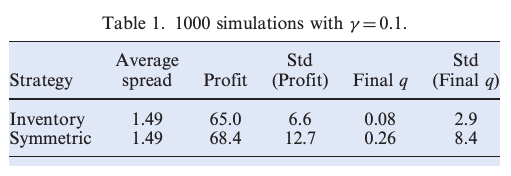

### Comparing the results to the Avellaneda Stoikov paper $\gamma = 0.01$

In [ ]:
num_trajectories = 1000
vec_env = get_as_env(num_trajectories)
vec_as = AvellanedaStoikovAgent(risk_aversion=0.01, env=vec_env)

In [ ]:
observations, actions, rewards = generate_trajectory(vec_env, vec_as)

In [ ]:
results, fig, total_rewards = generate_results_table_and_hist(vec_env=vec_env,agent=vec_as)

In [ ]:
results

These results look similar to Table 2 of Avellaneda and Stoikov, which is shown below. It is interesting that the agent **does** quote a negative spread sometimes, which _could_ be interpreted as taking liquidity but then the model should possibly be changed.

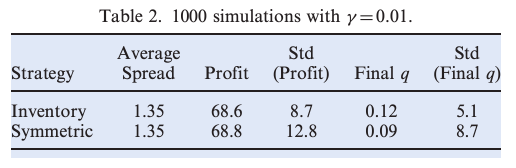